In [1]:
import numpy as np
import sys
from os.path import expanduser
from scipy import ndimage
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from astropy.wcs import WCS
import matplotlib
import pylab as plb
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
import warnings
import math
warnings.filterwarnings('ignore')
from IPython.display import Markdown as md


## Relative folder

In [2]:
home = expanduser("~")
datafolder=home+'/Desktop/mrk79/cubes/'  #The folder containing your .fits file
datafolder

'/home/apostolis/Desktop/mrk79/cubes/'

## Open fits file

In [3]:
mrk79_file='COcube.fits' #.fits file name
mrk79_fits=fits.open(datafolder+mrk79_file)[0]

## Fits header

In [4]:
mrk79_header=mrk79_fits.header
mrk79_header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                   97                                                  
NAXIS2  =                   97                                                  
NAXIS3  =                  190                                                  
NAXIS4  =                    1                                                  
DATAMIN = -0.6655395496637E-02         /                                        
DATAMAX =  0.2891516312957E-01         /                                        
BUNIT   = 'Jy/beam     '               /                                        
CTYPE1  = 'RA---ARC    '               /                                        
CRVAL1  =  0.1156366666667E+03         /                                        
CDELT1  = -0.1731111137690E-

## Data

In [5]:
mrk79_data=mrk79_fits.data
print(f'Shape of data is {mrk79_data.shape}, so this is not a cube, it has an extra dimension without a reason')
mrk79_data=mrk79_data[0]
print(f'Shape of data is {mrk79_data.shape}, seems fine, the dimensions is (z,y,x) (there is a (computation speed) reason for this, so it is better to keep this structure)')

Shape of data is (1, 190, 97, 97), so this is not a cube, it has an extra dimension without a reason
Shape of data is (190, 97, 97), seems fine, the dimensions is (z,y,x) (there is a (computation speed) reason for this, so it is better to keep this structure)


### Calculate the coordinates
From the header the z coordinate has velocity dimensions ```CTYPE3  = 'VRAD'``` in km/s ```CUNIT3  = 'km/s'```

From the header the x,y coordinates has RA/DEC dimensions ```CTYPE1  = 'RA---ARC'```,```CTYPE2  = 'DEC--ARC'``` in degrees```CUNIT1  = 'deg'```

In [6]:
dx = np.abs(mrk79_header['CDELT1'])*3600 #arcsec
dy = np.abs(mrk79_header['CDELT2'])*3600 #arcsec
dv = mrk79_header['CDELT3'] #km/s

ydec=np.linspace(-mrk79_data.shape[1]*dy/2. +mrk79_header["CRVAL2"],mrk79_data.shape[1]*dy/2.+mrk79_header["CRVAL2"],mrk79_header['NAXIS2'])
xra=np.linspace(-mrk79_data.shape[2]*dx/2. +mrk79_header["CRVAL1"],mrk79_data.shape[2]*dx/2.+mrk79_header["CRVAL1"],mrk79_header['NAXIS1'])

xx=np.linspace(-mrk79_data.shape[2]*dx/2.,mrk79_data.shape[2]*dx/2.,mrk79_header['NAXIS1']) #arcsec
yy=np.linspace(-mrk79_data.shape[1]*dx/2.,mrk79_data.shape[1]*dx/2.,mrk79_header['NAXIS2']) #arcsec

b=mrk79_header['CRVAL3']-mrk79_header['CRPIX3']*dv #zero point velocity
vv=np.linspace(b+dv,b+dv*mrk79_header['NAXIS3'],mrk79_header['NAXIS3'])  #velocity channels


### Make some plots

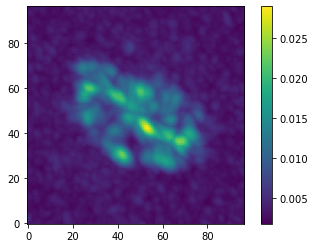

In [7]:
mrk79_max = np.nanmax(mrk79_data,axis=0) #collapse the cube along 0 dimension (velocity) by keeping only the maximum velocities 
plt.imshow(mrk79_max,origin='lower')
plt.colorbar()# Image plot, dimensions are pixels

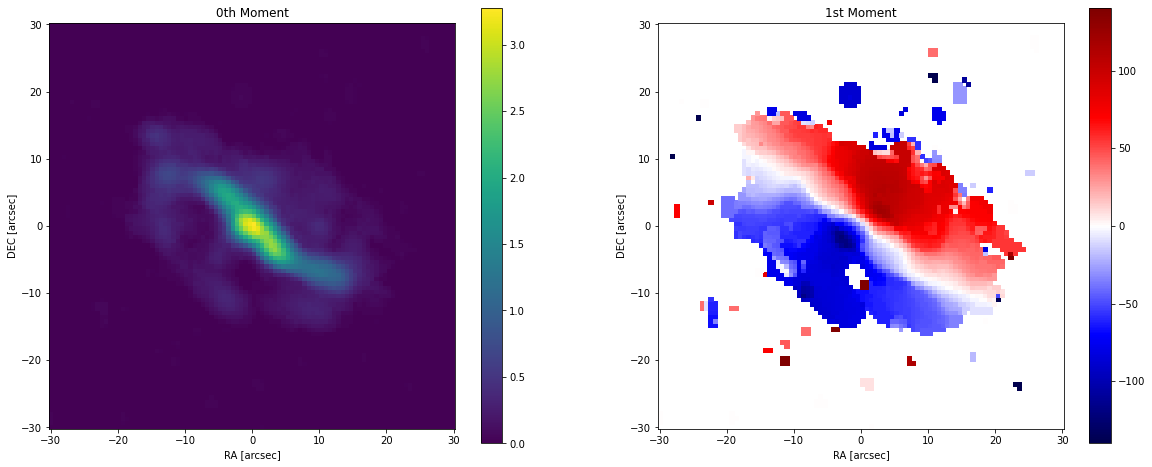

In [8]:
sigma=9.3859574E-4 #noise [Jy/beam]
fig, axes = plt.subplots(1,2,figsize=(20,8))
mrk79_mom0 = np.nansum(np.where(mrk79_data>=5*sigma,mrk79_data,0),axis=0)*np.abs(dv) #collapse the cube along 0 dimension (velocity) by summing (zeroth moment)
vv2=np.linspace(0,0,mrk79_header["NAXIS3"]) 
for i in range(190):
    vv2[i]=np.where(-300<=vv[i] and vv[i]<=300,vv[i],0)
mrk79_mom1=np.nansum(vv2[:,None,None]*np.where(mrk79_data>=5*sigma,mrk79_data,0),axis=0)/(mrk79_mom0/np.abs(dv)) #first moment
p0=axes[0].pcolormesh(xx,yy,mrk79_mom0,vmin=0)
axes[0].set(aspect=1,xlabel='RA [arcsec]',ylabel='DEC [arcsec]',title='0th Moment')
fig.colorbar(p0, ax=axes[0])
p1=axes[1].pcolormesh(xx,yy,mrk79_mom1,vmin=-140,vmax=140,cmap='seismic')
axes[1].set(aspect=1,xlabel='RA [arcsec]',ylabel='DEC [arcsec]',title='1st Moment')
fig.colorbar(p1, ax=axes[1])

### Extra: Calculate the intrinsic dimensions

arcsec to kpc conversion: 0.4630279249450416 kpc / arcsec
distance to mrk79: 99.79205841490912 Mpc


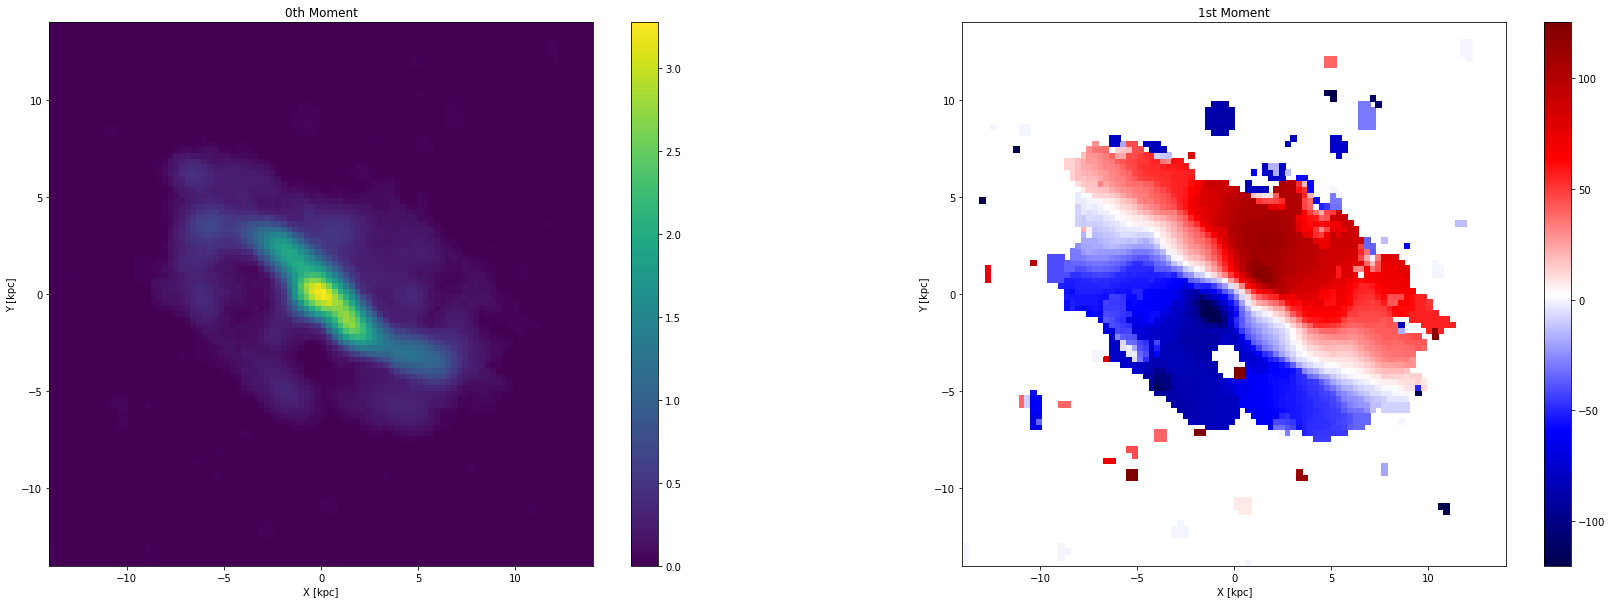

In [9]:
import astropy.units as u
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=67.8, Om0=0.3,Ode0=0.7) #create a cosmology
z=0.02219  #redshift
D=cosmo.luminosity_distance(z) #distance to the object
arctokpc = (cosmo.angular_diameter_distance(z=z)/206265).to(u.kpc)/u.arcsec
print("arcsec to kpc conversion:",arctokpc)
ak=arctokpc.value
print("distance to mrk79:",D)

xx_kpc=xx*ak
yy_kpc=yy*ak

fig, axes = plt.subplots(1,2,figsize=(30,10))

p0=axes[0].pcolormesh(xx_kpc,yy_kpc,mrk79_mom0)
axes[0].set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='0th Moment')
fig.colorbar(p0, ax=axes[0])

p1=axes[1].pcolormesh(xx_kpc,yy_kpc,mrk79_mom1,vmin=-120,vmax=125,cmap='seismic')
axes[1].set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='1st Moment')
fig.colorbar(p1, ax=axes[1])


## Position Velocity Plots

1.5630979089019734


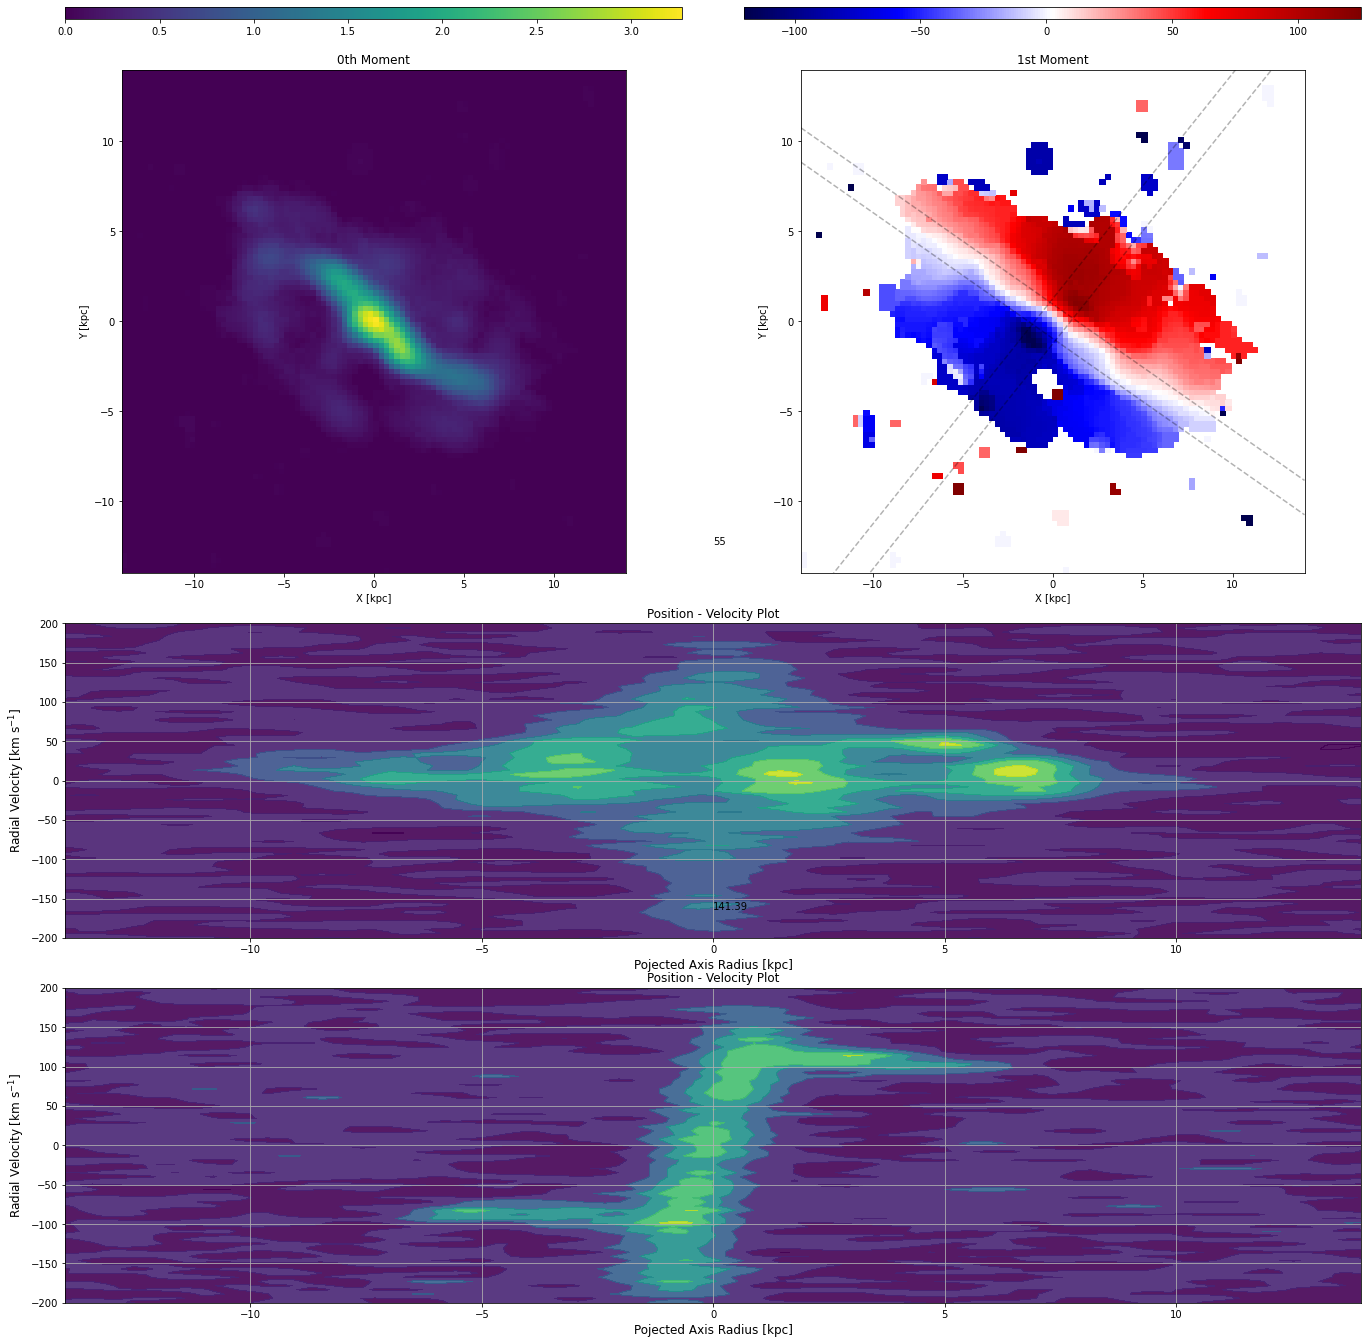

In [10]:
import matplotlib.gridspec as gridspec

papvds = [55,141.39]
dx_kpc=(dx)*ak #dx in kpc
slit=0.9377271654521E-03*ak*3600 #slit width in kpc
limy=[np.min(yy_kpc),np.max(yy_kpc)]
limv=[-200,200]

Nplots=len(papvds)
Ncubes = 1
fig = plt.figure(figsize=(20,10+5*Nplots))
gs=gridspec.GridSpec(2+Nplots, 2*Ncubes, height_ratios=[0.02,0.8]+[0.5]*Nplots, width_ratios=[0.8,0.8]*Ncubes)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.175)

ipx=0
axmom0 = fig.add_subplot(gs[1,ipx])
caxmom0 = fig.add_subplot(gs[0,ipx])
ipx=ipx+1
axmom1 = fig.add_subplot(gs[1,ipx])
caxmom1 = fig.add_subplot(gs[0,ipx])

cm0=axmom0.pcolormesh(xx_kpc,yy_kpc,mrk79_mom0)
plt.colorbar(cm0,cax=caxmom0,orientation='horizontal').ax.tick_params(labelsize=10)
axmom0.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='0th Moment')  

cm1=axmom1.pcolormesh(xx_kpc,yy_kpc,mrk79_mom1,vmin=-120,vmax=125,cmap='seismic')
plt.colorbar(cm1,cax=caxmom1,orientation='horizontal').ax.tick_params(labelsize=10)  
axmom1.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='1st Moment')   

ithick = int(round(slit/dx_kpc)) #number of pixels which are going to collapse (inside the slit)
ixc = round(mrk79_data.shape[2]/2) #where is the center in pixels

for j,papvd in enumerate(papvds):
    
    #Create and Plot the Slit(s)
    def yslit_low(x,pa): return slit/(2*np.cos(np.radians(pa+90))) +x*np.tan(np.radians(pa+90))
    def yslit_high(x,pa): return -slit/(2*np.cos(np.radians(pa+90))) +x*np.tan(np.radians(pa+90))
    axmom1.plot(xx_kpc,yslit_low(xx_kpc,papvds[j]),'--',alpha=0.3, color='black')
    axmom1.plot(xx_kpc,yslit_high(xx_kpc,papvds[j]),'--',alpha=0.3, color='black')
    axmom1.set(xlim=[np.min(xx_kpc),np.max(xx_kpc)],ylim=[np.min(yy_kpc),np.max(yy_kpc)])   

    axpvd = fig.add_subplot(gs[2+j,:])
    axpvd.text(x=np.mean(limy),y=300,s="{}".format(papvd))
    axpvd.set(title='Position - Velocity Plot')
    axpvd.set_xlabel('Pojected Axis Radius [kpc]',fontsize=12)
    axpvd.set_ylabel(r'Radial Velocity [km s$^{-1}$]',fontsize=12)

    axpvd.set_xlim(limy)
    axpvd.set_ylim(limv)
    axpvd.grid(True)
    
    #Create the Position-Velocity Graph
    rotcube=ndimage.interpolation.rotate(mrk79_data,papvd+180,axes=(2,1),reshape=False) #rotate the cube along 0 dimension
    
    #collapse the slit by summing 
    pvd_cube = np.nansum(rotcube[:,:,ixc-int(ithick/2):ixc+int(ithick/2)],axis=2)
    ppvd_res=axpvd.contourf(yy_kpc,vv,pvd_cube,alpha=0.9,vmin=0)
print(slit)

### 2nd Moment

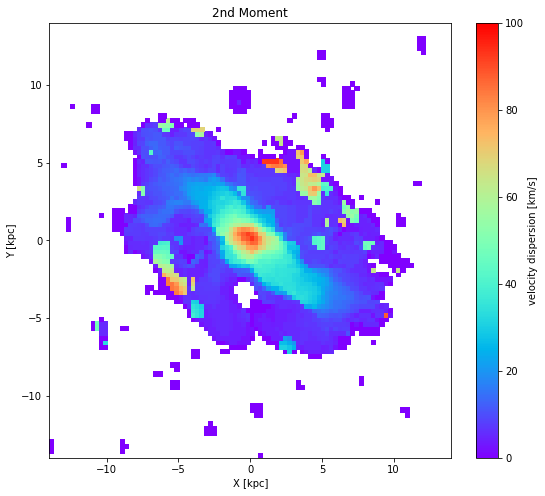

1.5630979089019734

In [11]:
mrk79_mom2=np.sqrt(np.nansum(np.where(mrk79_data>=5*sigma,mrk79_data,0)*(vv2[:,None,None]-mrk79_mom1)**2,axis=0)/(mrk79_mom0/np.abs(dv)))
plt.figure(figsize=(9,8))
plt.pcolormesh(xx_kpc,yy_kpc,mrk79_mom2,vmin=0,vmax=100, cmap='rainbow')
plt.colorbar(label='velocity dispersion [km/s]')
#plt.contour(xx_kpc,yy_kpc,mrk79_mom2,cmap='gray')
plt.xlabel("X [kpc]"), plt.ylabel("Y [kpc]")
plt.title("2nd Moment")
plt.show()
slit

### Inclination & Mass

In [12]:
from astropy import constants as const

GG=const.G.to('kpc3 / (kg s2)')
G=GG.value
vmax=122 #maximum rotational velocity corrected for inclination (HyperLeda)
vmax_kpc=(vmax*(u.km/u.s)).to(u.kpc/u.s)
a=(30.90)*ak #semi-major axis in kpc (2MASS)
b=(16.068)*ak
"""
    a=(30.90)*ak #semi-major axis in kpc (2MASS)
    da=0.33*ak
    b=(16.068)*ak #semi-minor axis in kpc (2MASS)
    db=0.33*ak
    sini=np.sqrt(1-(b/a)**2) #inclination
    dsini=(b/(a**2*sini))*np.sqrt((da*b/a)**2 + db**2)
    di=np.rad2deg(np.arcsin(dsini))
"""
inc=32.7    
sini=np.sin(np.deg2rad(inc)) #<---This is the inclination
cosi=np.cos(np.deg2rad(inc))
print("the inclination is i =","{:.4}".format(np.rad2deg(np.arcsin(sini))))  #,"+-","{:.2}".format(di),"deg")

Mkg=(a*(vmax_kpc.value)**2)/G
Msun=Mkg/const.M_sun.value

print("Mass of mrk79 =","{:.2e}".format(Msun),"M_sun")

the inclination is i = 32.7
Mass of mrk79 = 4.95e+10 M_sun


### Calculate the a parameter from the maximum velocity 

 a0  =  3.79 kpc


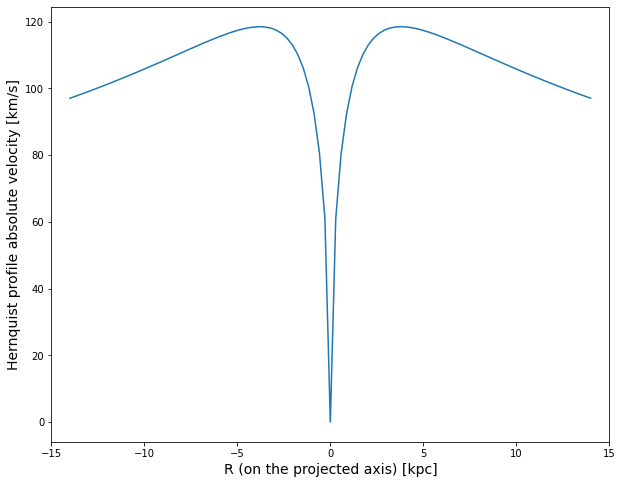

In [13]:
rr=yy_kpc
for a0 in enumerate(rr):
    vc=np.sqrt(G*Mkg*np.abs(rr))/(np.abs(rr)+np.abs(a0[1]))
    vc=((vc*(u.kpc/u.s)).to(u.km/u.s)).value
    if (vmax-4.7)<=np.max(vc) and np.max(vc)<=(vmax+4.7): 
        break
plt.figure(figsize=(10,8))
plt.plot(rr,vc)
plt.xlim(-15,15), plt.xlabel("R (on the projected axis) [kpc]",fontsize=14), plt.ylabel("Hernquist profile absolute velocity [km/s]",fontsize=14)
print(" a0  = ","{:.3}".format(np.abs(a0[1])),"kpc")


kms100=u.def_unit('kms100',100*u.km/u.s)
kms2100=u.def_unit('kms2100',(100*u.km/u.s)**2)
print(kms2100)
gg=const.G.to('(kpc kms2100/ (M_sun)')
gg


### Bertola model 

In [14]:
from scipy.optimize import curve_fit

def bertola(r,A,c,p):
    vc=A*r/((r**2+c**2)**(p/2))
    vc=vc
    return vc
def bertfit1d(velo,rr,inparam):
    popt, pcov = curve_fit(bertola,rr,velo,p0=inparam)#, bounds=[[0,-2,1],[500,2,1.5]])
    print('parameters of Bertola model: A=',"{:.5}".format(popt[0]),', c=',"{:.5}".format(popt[1]),', p=',"{:.5}".format(popt[2]))
    return popt

### Fitting of 1st Moment with the Hernquist profile

parameter a calculated from least squares fitting of Hernquist model: a= 1.749389 kpc

parameters of Bertola model: A= 395.75 , c= 1.4675 , p= 1.5199


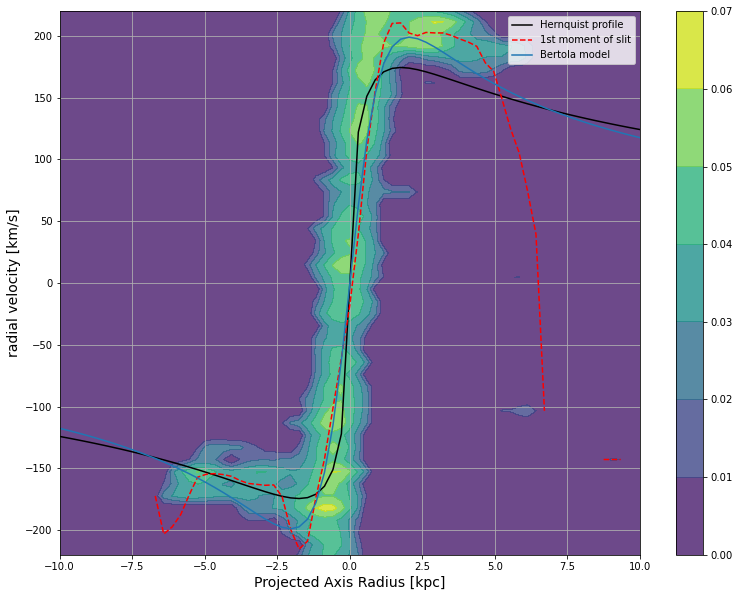

In [15]:

#Removing less than 5*sigma Intensities 
pvd_cubec=np.nansum(np.where(rotcube[:,:,ixc-int(ithick/2):ixc+int(ithick/2)]>=5*sigma,rotcube[:,:,ixc-int(ithick/2):ixc+int(ithick/2)],0),axis=2)

#if you don't want to remove low intensities just uncomment the line below 
#pvd_cubec=pvd_cube

mom0slit=np.nansum(pvd_cubec,axis=0)*np.abs(dv)
mom1slit=np.nansum(vv[:,None]*pvd_cubec,axis=0)/(mom0slit/np.abs(dv))

mom1slit=mom1slit/sini

def hern(r,a0): #Hernquist model velocity function
    vc=np.sqrt(G*Mkg*np.abs(r))/(np.abs(r)+np.abs(a0))
    vc=((vc*(u.kpc/u.s)).to(u.km/u.s)).value
    return vc

def errfhern(vh,velo): #error function of one position
    errf=np.nansum(np.abs(vh-np.abs(velo))**2,axis=0)
    return errf

def hernfit(velo):
    param_a=np.linspace(0,np.max(yy_kpc),len(yy_kpc)) #parameter a
    sum_err=np.linspace(0,0,len(param_a))

    for j, a00 in enumerate(param_a):
        vhern=hern(yy_kpc,a00)
    
        for i in range(len(yy_kpc)):
            sum_err[j]=sum_err[j]+errfhern(vhern[i],velo[i])
        sum_err[j]=((sum_err[j]))
    
    index_of_min_a0=np.where(sum_err==np.min(sum_err))  
    a0_min=param_a[index_of_min_a0]
    return a0_min

plt.figure(figsize=(13,10))
plt.plot(yy_kpc,np.where(yy_kpc<=0,-hern(yy_kpc,hernfit(mom1slit)),hern(yy_kpc,hernfit(mom1slit))),'k',label='Hernquist profile')
plt.plot(yy_kpc,mom1slit,'r--',label='1st moment of slit')
plt.contourf(yy_kpc,vv/sini,pvd_cubec,alpha=0.8)
plt.colorbar()
plt.grid(), plt.xlim(-10,10), plt.ylim(-220,220), plt.xlabel('Projected Axis Radius [kpc]',fontsize=14), plt.ylabel('radial velocity [km/s]',fontsize=14)

print('parameter a calculated from least squares fitting of Hernquist model: a=',"{:.8}".format(hernfit(mom1slit)[0]),'kpc\n')

m2=mom1slit[26:70]
m2=np.where(np.isnan(m2),0,m2)
init_param=[100,1,1]
bertolaparam=bertfit1d(m2,yy_kpc[26:70],init_param)

plt.plot(yy_kpc,bertola(yy_kpc,bertolaparam[0],bertolaparam[1],bertolaparam[2]),label='Bertola model')
plt.legend()
plt.show()

### Fitting every pixel spectrum with a Gaussian

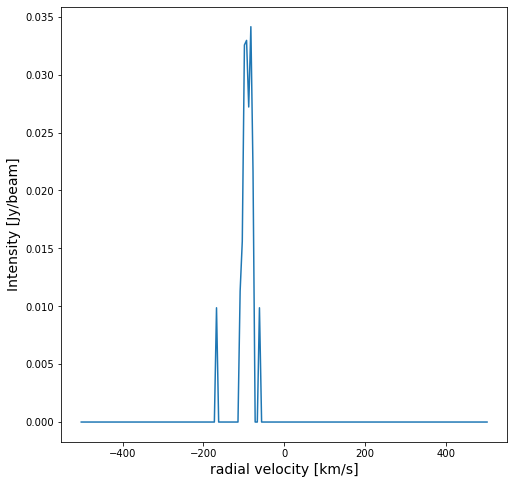

In [16]:
plt.figure(figsize=(8,8))
plt.plot(vv,pvd_cubec[:,40]) #Spectrum of one pixel
plt.xlabel('radial velocity [km/s]',fontsize=14), plt.ylabel('Intensity [Jy/beam]',fontsize=14)
plt.show()

parameter a calculated from least squares fitting of Hernquist model: a = 5.5397318 kpc 

parameters of Bertola model: A= 155.78 , c= 1.0603 , p= 1.3115


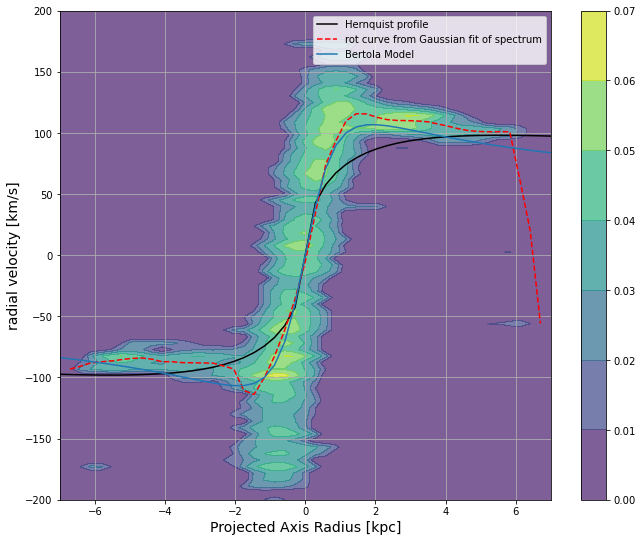

In [17]:
import pylab as plb
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

def gaus(x,a,x0,sigma):
    return a * np.exp(-(x-x0)**2/(2 * sigma**2))                                               

vv_slit=np.linspace(0,0,len(yy_kpc))                                                            

for k in range(len(yy_kpc)):
    mean=np.nansum(vv*pvd_cubec[:,k])/np.nansum(pvd_cubec[:,k])
    sig=np.sqrt(np.nansum(pvd_cubec[:,k] * (vv - mean)**2) /np.nansum(pvd_cubec[:,k]))
    popt,pcov = curve_fit(gaus,vv,pvd_cubec[:,k],p0=[np.nanmax(pvd_cubec[:,k]),mean,sig])
    vv_slit[k]=popt[1]

print('parameter a calculated from least squares fitting of Hernquist model: a =',"{:.8}".format(hernfit(vv_slit)[0]),'kpc \n')

plt.figure(figsize=(11,9))

plt.plot(yy_kpc,np.where(yy_kpc<=0,-hern(yy_kpc,hernfit(vv_slit)),hern(yy_kpc,hernfit(vv_slit))),'k',label='Hernquist profile')
plt.plot(yy_kpc,vv_slit,'r--',label='rot curve from Gaussian fit of spectrum')

plt.contourf(yy_kpc,vv,pvd_cubec,alpha=0.7), plt.colorbar()
plt.xlim(-7,7), plt.ylim(-200,200), plt.grid()
plt.xlabel('Projected Axis Radius [kpc]',fontsize=14), plt.ylabel('radial velocity [km/s]',fontsize=14)

vv_slit2=np.where(np.isnan(vv_slit[25:70]),0,vv_slit[25:70])
bert_param=bertfit1d(vv_slit2,yy_kpc[25:70],[100,5,1])
plt.plot(yy_kpc,bertola(yy_kpc,bert_param[0],bert_param[1],bert_param[2]),label='Bertola Model')
plt.legend()
plt.show()

### Rotation Curve from mean and maximum Intensities

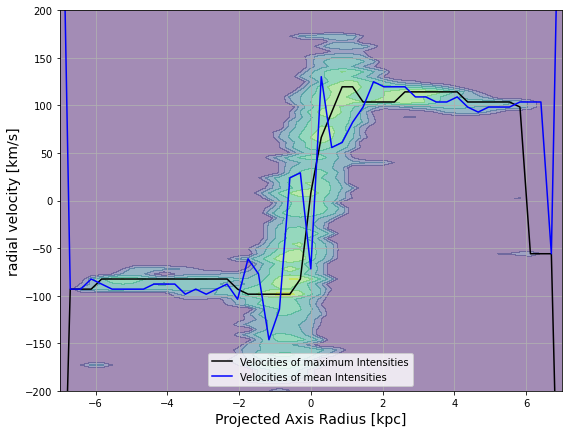

For maximum Intensities:

parameter a calculated from least squares fitting of Hernquist model: a = 1.4578242 kpc

parameters of Bertola model: A= 123.24 , c= 0.4926 , p= 1.2186

For mean Intensities:

parameter a calculated from least squares fitting of Hernquist model: a = 1.4578242 kpc

parameters of Bertola model: A= 163.82 , c= 1.3695 , p= 1.3049


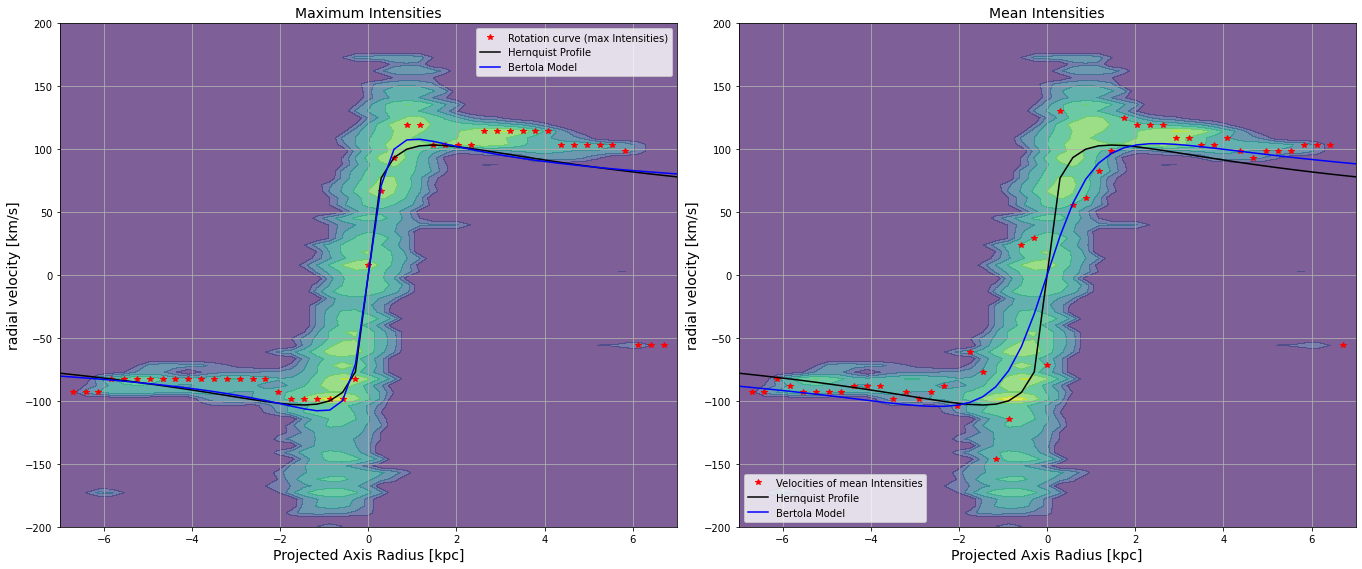

In [18]:
pvd_cubemax=np.linspace(0,0,mrk79_header['NAXIS1'])
pvd_cubemean=np.linspace(0,0,mrk79_header['NAXIS1'])

vmaxslit=np.linspace(0,0,mrk79_header['NAXIS1'])
vmeanslit=np.linspace(0,0,mrk79_header['NAXIS1'])

index=np.linspace(0,0,mrk79_header['NAXIS1'])
index2=np.linspace(0,0,mrk79_header['NAXIS1'])

for k in range(mrk79_header['NAXIS1']):
    for m in range(mrk79_header['NAXIS3']):
        if pvd_cubemax[k]<=pvd_cubec[m,k]:
            pvd_cubemax[k]=pvd_cubec[m,k]
            index[k]=m
        vmaxslit[k]=vv[int(index[k])]

for i in range(mrk79_header['NAXIS1']):
    pvd_cubemean[i]=np.nansum(pvd_cubec[:,i]**2,axis=0)/np.nansum(pvd_cubec[:,i],axis=0)
    diff=np.abs(pvd_cubemean[i]-pvd_cubec[0,i])
    index2[i]=0 
    for k in range(mrk79_header['NAXIS3']):
        if diff>=np.abs(pvd_cubemean[i]-pvd_cubec[k,i]):
            diff=np.abs(pvd_cubemean[i]-pvd_cubec[k,i])
            index2[i]=k
    vmeanslit[i]=vv[int(index2[i])]   

plt.figure(figsize=(9,7))
plt.contourf(yy_kpc,vv,pvd_cubec,alpha=0.5)
plt.plot(yy_kpc,vmaxslit,'k',label='Velocities of maximum Intensities')
plt.plot(yy_kpc,vmeanslit,'b',label='Velocities of mean Intensities')
plt.legend()
plt.xlim(-7,7), plt.ylim(-200,200), plt.grid()
plt.xlabel('Projected Axis Radius [kpc]',fontsize=14), plt.ylabel('radial velocity [km/s]',fontsize=14)
plt.show()

print('\033[1m'+'For maximum Intensities:\n'+'\033[0m')
print('parameter a calculated from least squares fitting of Hernquist model: a =',"{:.8}".format(hernfit(vmaxslit)[0]),'kpc\n')
bert_paramax=bertfit1d(vmaxslit[25:70],yy_kpc[25:70],[300,4,1.5])

print('\033[1m'+'\nFor mean Intensities:\n'+'\033[0m')
print('parameter a calculated from least squares fitting of Hernquist model: a =',"{:.8}".format(hernfit(vmeanslit)[0]),'kpc\n')
bert_paramean=bertfit1d(vmeanslit[25:70],yy_kpc[25:70],[300,4,1.5])

fig = plt.figure(figsize=(20,20))
gs=gridspec.GridSpec(4, 2, height_ratios=[0.02,0.8]+[0.5]*2, width_ratios=[0.8,0.8])
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.175)

axvelo_max = fig.add_subplot(gs[1,0])
axvelo_max.plot(yy_kpc,vmaxslit,'r*',label='Rotation curve (max Intensities)')
axvelo_max.plot(yy_kpc,sini*np.where(yy_kpc<=0,-hern(yy_kpc,hernfit(vmaxslit)),hern(yy_kpc,hernfit(vmaxslit))),'k',label='Hernquist Profile')
axvelo_max.plot(yy_kpc,bertola(yy_kpc,bert_paramax[0],bert_paramax[1],bert_paramax[2]),'b', label='Bertola Model')
plt.legend()
axvelo_max.contourf(yy_kpc,vv,pvd_cubec,alpha=0.7)
plt.xlabel('Projected Axis Radius [kpc]',fontsize=14), plt.ylabel('radial velocity [km/s]',fontsize=14)
plt.xlim(-7,7), plt.ylim(-200,200), plt.grid()
plt.title('Maximum Intensities', fontsize=14)

axvelo_mean = fig.add_subplot(gs[1,1])
axvelo_mean.plot(yy_kpc,vmeanslit,'r*',label='Velocities of mean Intensities')
axvelo_mean.plot(yy_kpc,sini*np.where(yy_kpc<=0,-hern(yy_kpc,hernfit(vmeanslit)),hern(yy_kpc,hernfit(vmeanslit))),'k',label='Hernquist Profile')
axvelo_mean.plot(yy_kpc,bertola(yy_kpc,bert_paramean[0],bert_paramean[1],bert_paramean[2]),'b', label='Bertola Model')
plt.legend()
axvelo_mean.contourf(yy_kpc,vv,pvd_cubec,alpha=0.7)
plt.xlabel('Projected Axis Radius [kpc]',fontsize=14), plt.ylabel('radial velocity [km/s]',fontsize=14)
plt.xlim(-7,7), plt.ylim(-200,200), plt.grid()
plt.title('Mean Intensities', fontsize=14)
plt.show()

### Bertola Velocity Field

In [23]:
# This is the function used to do the fit
def velf_bert(xy_mesh,incl,pa): # xy_mesh is not used inside the function, it is just needed for the curve_fit function 
    A=bert_param[0]
    c=bert_param[1]
    p=bert_param[2]   
    xcen=ycen=48
    cosin=np.cos(np.deg2rad(incl))
    sinin=np.sin(np.deg2rad(incl))
    ci=cosin; si=sinin; cp=np.cos(np.deg2rad(pa)); sp=np.sin(np.deg2rad(pa))
    g=np.zeros(shape=(len(xx_kpc),len(yy_kpc)))
    tiny=0.001
    for i in range(0,len(xx_kpc)):
        for j in range(0,len(yy_kpc)):
            x=dx_kpc*(i-xcen)
            y=dx_kpc*(j-ycen)
            xpr=(-x*sp+y*cp)
            ypr=(-x*cp-y*sp)/ci
            xr=np.sqrt(xpr**2+ypr**2)
            the=math.acos(ypr/(np.max(xr)+tiny))
            
            if xpr<=0:
                the=the
            else:
                the=-the
            the=the+np.deg2rad(-pa)
            
            g[i,j]=(A*xr*np.cos(the)*si*ci**p)/(xr**2*(np.sin(the)**2+ci**2*np.cos(the)**2)+c**2*ci**2)**(p/2)
    g=np.where(np.isnan(mrk79_mom1),0,g)
    return np.ravel(g)

### Fit of 1st Moment

In [24]:
fit_init_params=[inc,papvds[0],bert_param[0],bert_param[1],bert_param[2]]  #inclination, PA
fit_init_params2=[inc,papvds[0]]
X,Y=np.meshgrid(xx_kpc,yy_kpc)
ydata=np.where(np.isnan(mrk79_mom1),0,mrk79_mom1).ravel()
xy_mesh=np.meshgrid(xx_kpc,yy_kpc)
inc_pa,covar=curve_fit(velf_bert,xy_mesh,ydata,p0=fit_init_params2,sigma=np.linspace(np.abs(dv),np.abs(dv),len(ydata)),absolute_sigma=True,bounds=(0,[90,180]))


### Fit only inclination and PA

Fitted parameters:
inclination =  40.03  deg
PA =  110.86  deg


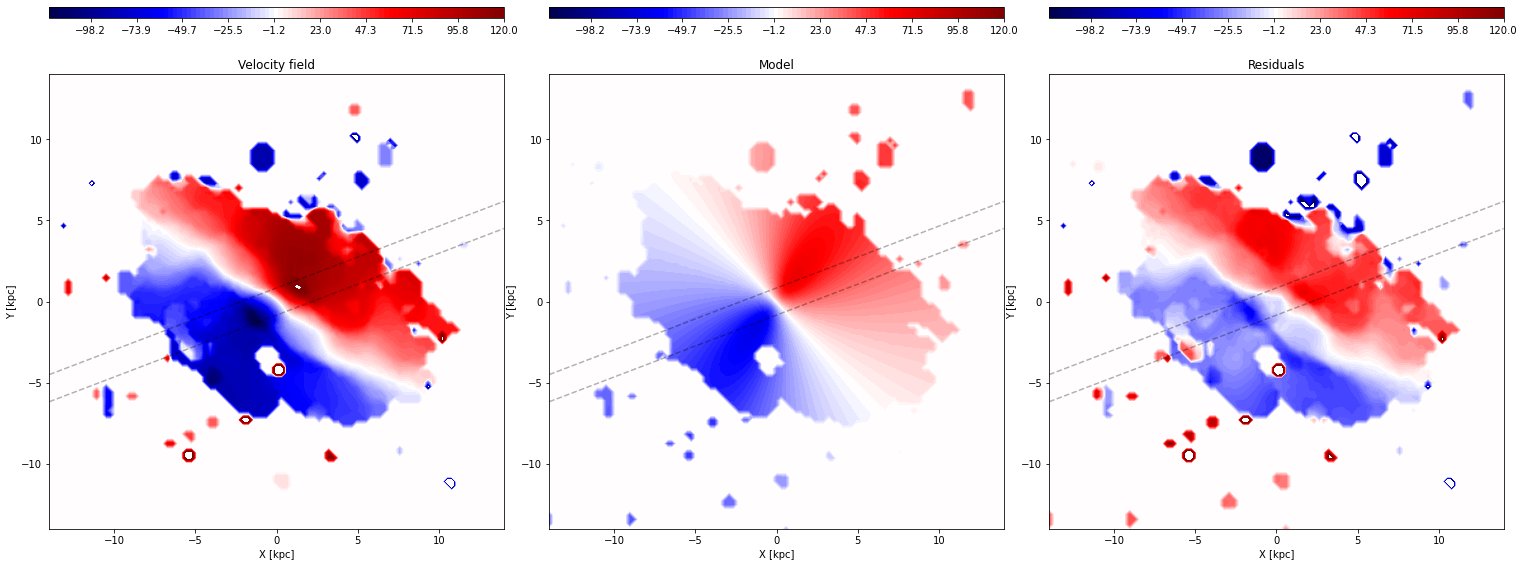

In [25]:
print("Fitted parameters:\ninclination = ","{:.4}".format(inc_pa[0])," deg\nPA = ","{:.5}".format(inc_pa[1])," deg")
vf_fit=velf_bert(xy_mesh,inc_pa[0],inc_pa[1])


fig = plt.figure(figsize=(20,16))
gs=gridspec.GridSpec(3, 3, height_ratios=[0.02,0.8,0.8], width_ratios=[0.4,0.4,0.4])
gs.update(left=0.05, right=1.06, bottom=0.05, top=0.95, wspace=0.1, hspace=0.175)

ax0 = fig.add_subplot(gs[1,0])
cax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,1])
cax1 = fig.add_subplot(gs[0,1])
ax2=fig.add_subplot(gs[1,2])
cax2=fig.add_subplot(gs[0,2])

c0=ax0.contourf(xx_kpc,yy_kpc,ydata.reshape(len(xx),len(yy)),vmin=-120,vmax=120,cmap='seismic',levels=np.linspace(-120,120,100))
plt.colorbar(c0,cax=cax0,orientation='horizontal').ax.tick_params(labelsize=10)
ax0.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Velocity field')  
ax0.plot(xx_kpc,yslit_low(xx_kpc,inc_pa[1]),'--',alpha=0.3, color='black')
ax0.plot(xx_kpc,yslit_high(xx_kpc,inc_pa[1]),'--',alpha=0.3, color='black')
ax0.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
ax0.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])

c1=ax1.contourf(xx_kpc,yy_kpc,vf_fit.reshape(len(xx),len(yy)),cmap='seismic',vmin=-120,vmax=120,levels=np.linspace(-120,120,100))
plt.colorbar(c1,cax=cax1,orientation='horizontal').ax.tick_params(labelsize=10)  
ax1.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Model')   
ax1.plot(xx_kpc,yslit_low(xx_kpc,inc_pa[1]),'--',alpha=0.3, color='black')
ax1.plot(xx_kpc,yslit_high(xx_kpc,inc_pa[1]),'--',alpha=0.3, color='black')
ax1.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
ax1.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])

c2=ax2.contourf(xx_kpc,yy_kpc,ydata.reshape(len(xx),len(yy))-vf_fit.reshape(len(xx),len(yy)),vmin=-120,vmax=120 ,cmap='seismic',levels=np.linspace(-120,120,100))
plt.colorbar(c2,cax=cax2,orientation='horizontal').ax.tick_params(labelsize=10)
ax2.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Residuals')   
ax2.plot(xx_kpc,yslit_low(xx_kpc,inc_pa[1]),'--',alpha=0.3, color='black')
ax2.plot(xx_kpc,yslit_high(xx_kpc,inc_pa[1]),'--',alpha=0.3, color='black')
ax2.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
ax2.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])

plt.show()

### Fit of A,c,p and inc,PA

In [26]:
def velf_bert2(xy_mesh,incl,pa,A,c,p): # xy_mesh is not used inside the function, it is just needed for the curve_fit function       
    xcen=ycen=48
    cosin=np.cos(np.deg2rad(incl))
    sinin=np.sin(np.deg2rad(incl))
    ci=cosin; si=sinin; cp=np.cos(np.deg2rad(pa)); sp=np.sin(np.deg2rad(pa))
    g=np.zeros(shape=(len(xx_kpc),len(yy_kpc)))
    tiny=0.001
    for i in range(0,len(xx_kpc)):
        for j in range(0,len(yy_kpc)):
            x=dx_kpc*(i-xcen)
            y=dx_kpc*(j-ycen)
            xpr=(-x*sp+y*cp)#/ci
            ypr=(-x*cp-y*sp)/ci
            xr=np.sqrt(xpr**2+ypr**2)
            the=math.acos(ypr/(np.max(xr)+tiny))
            
            if xpr<=0:
                the=the
            else:
                the=-the
            the=the+np.deg2rad(-pa)
            
            g[i,j]=(A*xr*np.cos(the)*si*ci**p)/(xr**2*(np.sin(the)**2+ci**2*np.cos(the)**2)+c**2*ci**2)**(p/2)
    g=np.where(np.isnan(mrk79_mom1),0,g)
    return np.ravel(g)

fit_init_params2=[inc_pa[0],inc_pa[1],bert_param[0],bert_param[1],bert_param[2]]  #inclination, PA
par,cov=curve_fit(velf_bert2,xy_mesh,ydata,p0=fit_init_params2,sigma=np.linspace(np.abs(dv),np.abs(dv),len(ydata)),absolute_sigma=True,bounds=([20,100,0,-2,1],[70,150,5000,1000,1.5]))


Fitted parameters:
inclination =  20.0  deg
PA =  109.07  deg
A =  539.97 
c =  1.0413 
p =  1.5


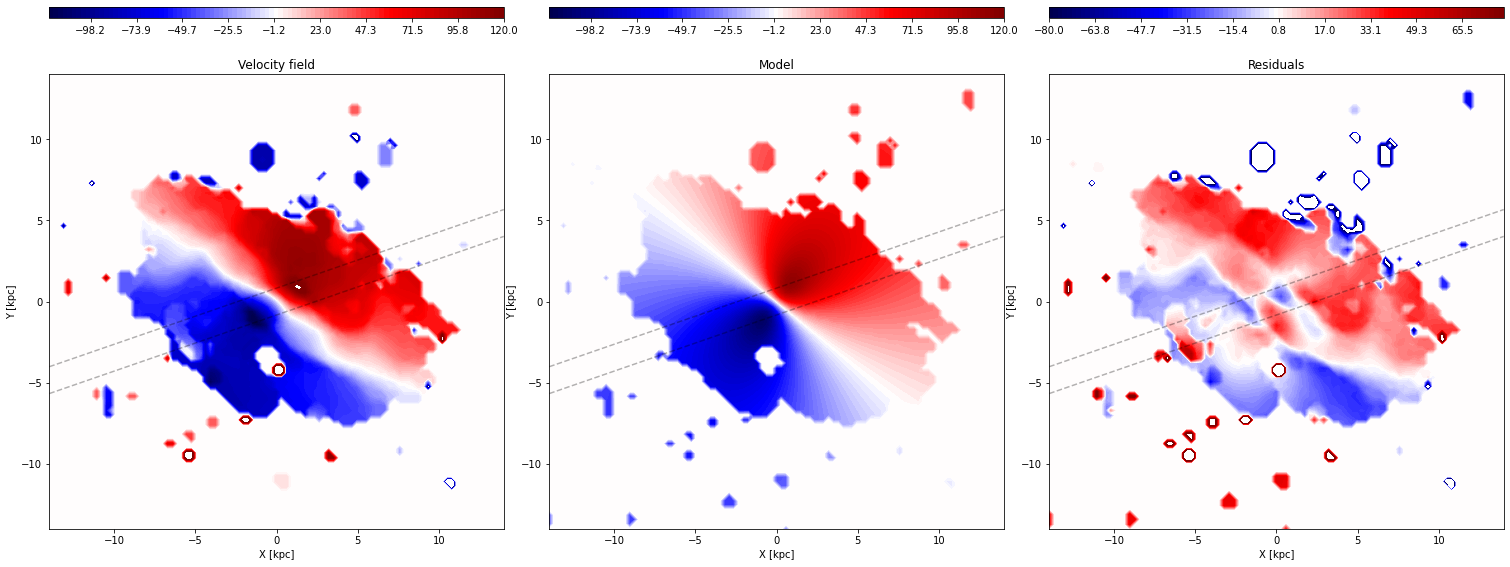

In [27]:
vf_fit2=velf_bert2(xy_mesh,par[0],par[1],par[2],par[3],par[4])


print("Fitted parameters:\ninclination = ","{:.4}".format(par[0])," deg\nPA = ","{:.5}".format(par[1])," deg\nA = ","{:.5}".format(par[2]),"\nc = ","{:.5}".format(par[3]),"\np = ","{:.5}".format(par[4]))

fig = plt.figure(figsize=(20,16))
gs=gridspec.GridSpec(3, 3, height_ratios=[0.02,0.8,0.8], width_ratios=[0.4,0.4,0.4])
gs.update(left=0.05, right=1.06, bottom=0.05, top=0.95, wspace=0.1, hspace=0.175)

ax0 = fig.add_subplot(gs[1,0])
cax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,1])
cax1 = fig.add_subplot(gs[0,1])
ax2=fig.add_subplot(gs[1,2])
cax2=fig.add_subplot(gs[0,2])

c0=ax0.contourf(xx_kpc,yy_kpc,ydata.reshape(len(xx),len(yy)),vmin=-120,vmax=120,levels=np.linspace(-120,120,100),cmap='seismic')
plt.colorbar(c0,cax=cax0,orientation='horizontal').ax.tick_params(labelsize=10)
ax0.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Velocity field')  
ax0.plot(xx_kpc,yslit_low(xx_kpc,par[1]),'--',alpha=0.3, color='black')
ax0.plot(xx_kpc,yslit_high(xx_kpc,par[1]),'--',alpha=0.3, color='black')
ax0.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
ax0.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])

c1=ax1.contourf(xx_kpc,yy_kpc,vf_fit2.reshape(len(xx),len(yy)),cmap='seismic',vmin=-120,vmax=120,levels=np.linspace(-120,120,100))
plt.colorbar(c1,cax=cax1,orientation='horizontal').ax.tick_params(labelsize=10)  
ax1.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Model')   
ax1.plot(xx_kpc,yslit_low(xx_kpc,par[1]),'--',alpha=0.3, color='black')
ax1.plot(xx_kpc,yslit_high(xx_kpc,par[1]),'--',alpha=0.3, color='black')
ax1.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
ax1.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])

c2=ax2.contourf(xx_kpc,yy_kpc,ydata.reshape(len(xx),len(yy))-vf_fit2.reshape(len(xx),len(yy)),cmap='seismic',levels=np.linspace(-80,80,100))
plt.colorbar(c2,cax=cax2,orientation='horizontal').ax.tick_params(labelsize=10)
ax2.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Residuals')   
ax2.plot(xx_kpc,yslit_low(xx_kpc,par[1]),'--',alpha=0.3, color='black')
ax2.plot(xx_kpc,yslit_high(xx_kpc,par[1]),'--',alpha=0.3, color='black')
ax2.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
ax2.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])

plt.show()

### Tilted Ring Method

In [28]:
dr=slit/2#<--ring width
par_rings=np.array([])
num_of_rings=25
#r_thick=np.linspace(slit/4,0.2*num_of_rings*slit/4,num_of_rings) #ring width increases
for l in range(num_of_rings):

    def bert_rings(xy_mesh,incl,pa):  #This is used for the fit
        A=par[2]
        c=par[3]
        p=par[4]
   
        xcen=ycen=48
        g=[]
        cosin=np.cos(np.deg2rad(incl))
        sinin=np.sin(np.deg2rad(incl))
        ci=cosin; si=sinin; cp=np.cos(np.deg2rad(pa)); sp=np.sin(np.deg2rad(pa))
        
        tiny=0.001
        np_ring=0
        for i in range(len(xx_kpc)):
            for j in range(len(yy_kpc)):
                x=dx_kpc*(i-xcen)
                y=dx_kpc*(j-ycen)
                xpr=(-x*sp+y*cp)
                ypr=(-x*cp-y*sp)/ci
                rr=np.sqrt(x**2+y**2)
                xr=np.sqrt(xpr**2+ypr**2)
                if rr<=(l+1)*dr and rr>=l*dr:
                    the=math.acos(ypr/((xr)+tiny))

                    if xpr<=0:
                        the=the
                    else:
                        the=-the
                    the=the+np.deg2rad(-pa)
                    if np.isnan(mrk79_mom1[i,j]):
                        g=np.append(g,0)
                    else:
                        g=np.append(g,(A*xr*np.cos(the)*si*ci**p)/(xr**2*(np.sin(the)**2+ci**2*np.cos(the)**2)+c**2*ci**2)**(p/2))                  
                    np_ring+=1        
        return g
    
    def moment1_rings(): #Gets the moment1 map values for each ring
        ring_m1=np.array([])
        xcen=ycen=48

        for i in range (len(xx)):
            for j in range(len(yy)):
                x=dx_kpc*(i-xcen)
                y=dx_kpc*(j-ycen)
                radius=np.sqrt(x**2+y**2)
                if radius<=(l+1)*dr and radius>=l*dr:
                    ring_m1=np.append(ring_m1,mrk79_mom1[i,j])
        return np.where(np.isnan(ring_m1),0,ring_m1)
    
    par_ring=curve_fit(bert_rings,xy_mesh,moment1_rings(),p0=[inc_pa[0],inc_pa[1]],sigma=np.linspace(np.abs(dv),np.abs(dv),len(moment1_rings())),absolute_sigma=True,bounds=([1,100],[89,180]))
    par_rings=np.append(par_rings,par_ring[0])

25
Fit only Inclination and PA


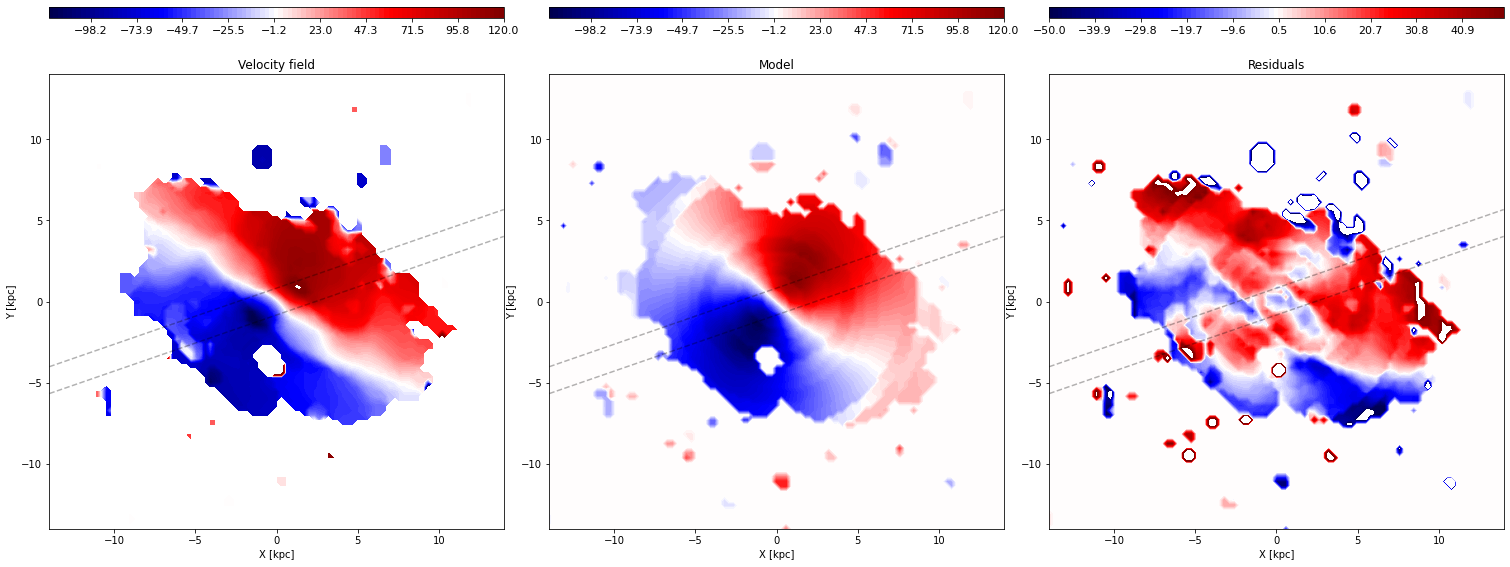

0.7815489544509867
ring 0 	Middle Radius: 0.39077447722549336 	inclination: 1.3376e+01 	PA: 1.1064e+02
ring 3 	Middle Radius: 2.7354213405784535 	inclination: 2.1796e+01 	PA: 1.0896e+02
ring 6 	Middle Radius: 5.080068203931414 	inclination: 2.1442e+01 	PA: 1.0838e+02
ring 9 	Middle Radius: 7.424715067284374 	inclination: 1.8445e+01 	PA: 1.0626e+02
ring 12 	Middle Radius: 9.769361930637334 	inclination: 5.6028e+00 	PA: 1.5902e+02
ring 15 	Middle Radius: 12.114008793990294 	inclination: 1.0544e+01 	PA: 1.4181e+02
ring 18 	Middle Radius: 14.458655657343254 	inclination: 4.0033e+01 	PA: 1.1086e+02
ring 21 	Middle Radius: 16.803302520696214 	inclination: 1.0000e+00 	PA: 1.0000e+02
ring 24 	Middle Radius: 19.147949384049173 	inclination: 1.0000e+00 	PA: 1.0000e+02


In [29]:
print(num_of_rings)
def ring_vf(incl,pa,nring): #Creates a velocity field for every ring, where outside the rings the values are 0
    A=par[2]
    c=par[3]
    p=par[4]

    xcen=ycen=48
    g=np.zeros(shape=(len(xx), len(yy)))
    cosin=np.cos(np.deg2rad(incl))
    sinin=np.sin(np.deg2rad(incl))
    ci=cosin; si=sinin; cp=np.cos(np.deg2rad(pa)); sp=np.sin(np.deg2rad(pa))

    tiny=0.001
    np_ring=0
    for i in range(len(xx_kpc)):
        for j in range(len(yy_kpc)):
            x=dx_kpc*(i-xcen)
            y=dx_kpc*(j-ycen)
            xpr=(-x*sp+y*cp)#/ci
            ypr=(-x*cp-y*sp)/ci
            rr=np.sqrt(x**2+y**2)
            xr=np.sqrt(xpr**2+ypr**2)
            if rr<=(nring+1)*dr and rr>=nring*dr:
                the=math.acos(ypr/(np.max(xr)+tiny))

                if xpr<=0:
                    the=the
                else:
                    the=-the
                the=the+np.deg2rad(-pa)
                if np.isnan(mrk79_mom1[i,j]):
                    g[i,j]=0
                else:
                    g[i,j]=(A*xr*np.cos(the)*si*ci**p)/(xr**2*(np.sin(the)**2+ci**2*np.cos(the)**2)+c**2*ci**2)**(p/2)                 
                np_ring+=1   
    return g
model_image=np.zeros(shape=(len(xx),len(yy)))
for l in range(num_of_rings): 
    #dr=r_thick[l]
    model_image=model_image+ring_vf(par_rings[2*l],par_rings[2*l+1],l) #Adding all the ring velocity fields

fig = plt.figure(figsize=(20,16))
gs=gridspec.GridSpec(3, 3, height_ratios=[0.02,0.8,0.8], width_ratios=[0.4,0.4,0.4])
gs.update(left=0.05, right=1.06, bottom=0.05, top=0.95, wspace=0.1, hspace=0.175)

ax0 = fig.add_subplot(gs[1,0])
cax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,1])
cax1 = fig.add_subplot(gs[0,1])
ax2=fig.add_subplot(gs[1,2])
cax2=fig.add_subplot(gs[0,2])

c0=ax0.contourf(xx_kpc,yy_kpc,mrk79_mom1,vmin=-120,vmax=120,levels=np.linspace(-120,120,100),cmap='seismic')
plt.colorbar(c0,cax=cax0,orientation='horizontal').ax.tick_params(labelsize=11)
ax0.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Velocity field')  
ax0.plot(xx_kpc,yslit_low(xx_kpc,par[1]),'--',alpha=0.3, color='black')
ax0.plot(xx_kpc,yslit_high(xx_kpc,par[1]),'--',alpha=0.3, color='black')
ax0.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
ax0.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])

c1=ax1.contourf(xx_kpc,yy_kpc,model_image,cmap='seismic',vmin=-120,vmax=120,levels=np.linspace(-120,120,100))
plt.colorbar(c1,cax=cax1,orientation='horizontal').ax.tick_params(labelsize=11)  
ax1.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Model')   
ax1.plot(xx_kpc,yslit_low(xx_kpc,par[1]),'--',alpha=0.3, color='black')
ax1.plot(xx_kpc,yslit_high(xx_kpc,par[1]),'--',alpha=0.3, color='black')
ax1.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
ax1.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])

c2=ax2.contourf(xx_kpc,yy_kpc,ydata.reshape(len(xx),len(yy))-model_image,alpha=1,vmin=-50,vmax=50 ,cmap='seismic',levels=np.linspace(-50,50,100))
plt.colorbar(c2,cax=cax2,orientation='horizontal').ax.tick_params(labelsize=11)
ax2.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Residuals')   
ax2.plot(xx_kpc,yslit_low(xx_kpc,par[1]),'--',alpha=0.3, color='black')
ax2.plot(xx_kpc,yslit_high(xx_kpc,par[1]),'--',alpha=0.3, color='black')
ax2.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
ax2.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])
print("Fit only Inclination and PA")
plt.show()
print(dr)
for l in range(0,num_of_rings,3):
    print('ring',l,'\tMiddle Radius:',(2*l+1)*dr/2, '\tinclination:', "{:.4e}".format(par_rings[2*l]), '\tPA:', "{:.4e}".format(par_rings[2*l+1]))


In [30]:
dr=slit/2 #<--ring width
par_rings=np.array([])
num_of_rings=25
#r_thick=np.linspace(slit/4,0.2*num_of_rings*slit/4,num_of_rings)
for l in range(num_of_rings):
    #dr=r_thick[l]
    
    def bert_rings(xy_mesh,incl,pa,A,c,p):  #This is used for the fit
        
        
        xcen=ycen=48
        g=[]
        cosin=np.cos(np.deg2rad(incl))
        sinin=np.sin(np.deg2rad(incl))
        ci=cosin; si=sinin; cp=np.cos(np.deg2rad(pa)); sp=np.sin(np.deg2rad(pa))
        
        tiny=0.001
        np_ring=0
        for i in range(len(xx_kpc)):
            for j in range(len(yy_kpc)):
                x=dx_kpc*(i-xcen)
                y=dx_kpc*(j-ycen)
                xpr=(-x*sp+y*cp)#/ci
                ypr=(-x*cp-y*sp)/ci
                rr=np.sqrt(x**2+y**2)
                xr=np.sqrt(xpr**2+ypr**2)
                if rr<=(l+1)*dr and rr>=l*dr:
                    the=math.acos(ypr/((xr)+tiny))

                    if xpr<=0:
                        the=the
                    else:
                        the=-the
                    the=the+np.deg2rad(-pa)
                    if np.isnan(mrk79_mom1[i,j]):
                        g=np.append(g,0)
                    else:
                        g=np.append(g,(A*xr*np.cos(the)*si*ci**p)/(xr**2*(np.sin(the)**2+ci**2*np.cos(the)**2)+c**2*ci**2)**(p/2))                  
                    np_ring+=1        
        return g
    
    def moment1_rings(): #Gets the moment1 map values for each ring
        ring_m1=np.array([])
        xcen=ycen=48

        for i in range (len(xx)):
            for j in range(len(yy)):
                x=dx_kpc*(i-xcen)
                y=dx_kpc*(j-ycen)
                radius=np.sqrt(x**2+y**2)
                if radius<=(l+1)*dr and radius>=l*dr:
                    ring_m1=np.append(ring_m1,mrk79_mom1[i,j])
        return np.where(np.isnan(ring_m1),0,ring_m1)
    
    par_ring=curve_fit(bert_rings,xy_mesh,moment1_rings(),p0=[inc_pa[0],par[1],par[2],par[3],par[4]],sigma=np.linspace(np.abs(dv),np.abs(dv),len(moment1_rings())),absolute_sigma=True,bounds=([15,100,0,-2,1],[60,180,1000,5,1.5]))
    par_rings=np.append(par_rings,par_ring[0])

Fit all parameters


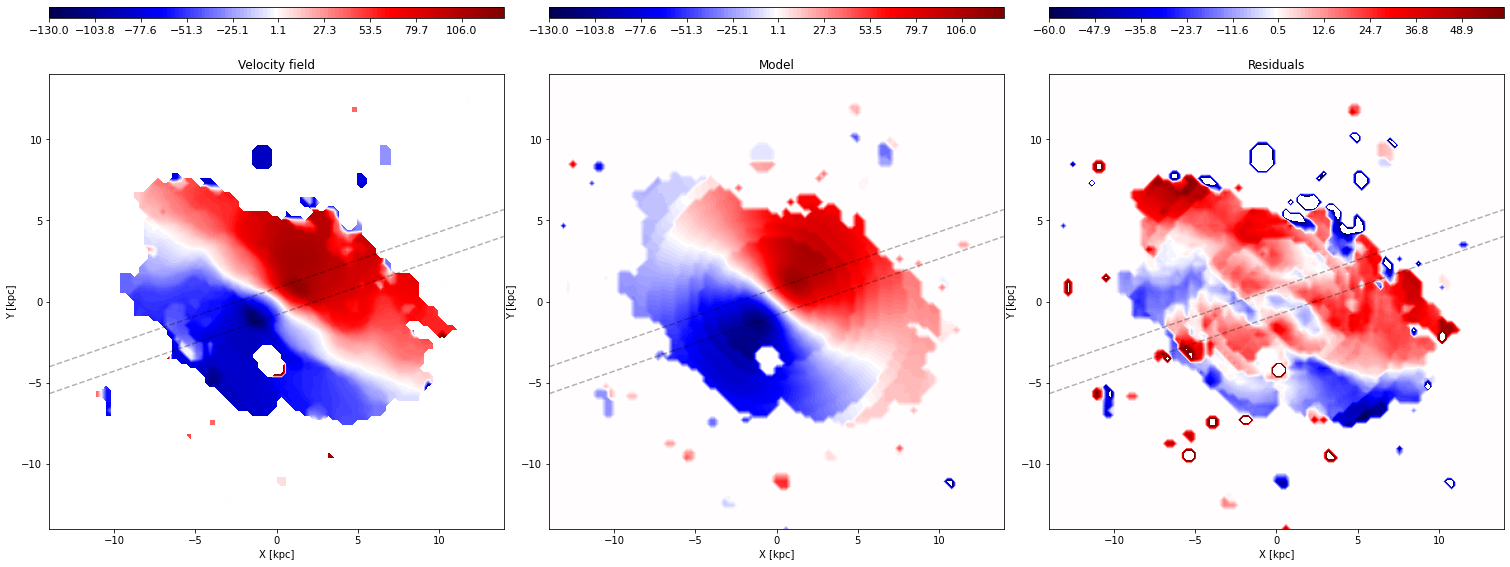

ring 0 	Middle of ring: 0.39077447722549336 	inclination: 2.8439e+01 	PA: 1.0964e+02
ring 3 	Middle of ring: 2.7354213405784535 	inclination: 1.5000e+01 	PA: 1.0898e+02
ring 6 	Middle of ring: 5.080068203931414 	inclination: 1.5000e+01 	PA: 1.0840e+02
ring 9 	Middle of ring: 7.424715067284374 	inclination: 1.5000e+01 	PA: 1.0607e+02
ring 12 	Middle of ring: 9.769361930637334 	inclination: 5.9992e+01 	PA: 1.4213e+02
ring 15 	Middle of ring: 12.114008793990294 	inclination: 6.0000e+01 	PA: 1.2904e+02
ring 18 	Middle of ring: 14.458655657343254 	inclination: 4.0033e+01 	PA: 1.0907e+02
ring 21 	Middle of ring: 16.803302520696214 	inclination: 1.5000e+01 	PA: 1.0000e+02
ring 24 	Middle of ring: 19.147949384049173 	inclination: 1.5000e+01 	PA: 1.0000e+02


In [36]:
def ring_vf(incl,pa,A,c,p,nring): #Creates a velocity field for every ring, where outside the rings the values are 0
    
    xcen=ycen=48
    g=np.zeros(shape=(len(xx), len(yy)))
    cosin=np.cos(np.deg2rad(incl))
    sinin=np.sin(np.deg2rad(incl))
    ci=cosin; si=sinin; cp=np.cos(np.deg2rad(pa)); sp=np.sin(np.deg2rad(pa))

    tiny=0.001
    np_ring=0
    for i in range(len(xx_kpc)):
        for j in range(len(yy_kpc)):
            x=dx_kpc*(i-xcen)
            y=dx_kpc*(j-ycen)
            xpr=(-x*sp+y*cp)
            ypr=(-x*cp-y*sp)/ci
            rr=np.sqrt(x**2+y**2)
            xr=np.sqrt(xpr**2+ypr**2)
            if rr<=(nring+1)*dr and rr>=nring*dr:
                the=math.acos(ypr/(xr+tiny))

                if xpr<=0:
                    the=the
                else:
                    the=-the
                the=the+np.deg2rad(-pa)
                if np.isnan(mrk79_mom1[i,j]):
                    g[i,j]=0
                else:
                    g[i,j]=(A*xr*np.cos(the)*si*ci**p)/(xr**2*(np.sin(the)**2+ci**2*np.cos(the)**2)+c**2*ci**2)**(p/2)                 
                np_ring+=1   
    #g=np.where(np.isnan(mrk79_mom1),0,g)
    return g
model_image=np.zeros(shape=(len(xx),len(yy)))
for l in range(num_of_rings): 
    #dr=r_thick[l]
    model_image=model_image+ring_vf(par_rings[5*l],par_rings[5*l+1],par_rings[5*l+2],par_rings[5*l+3],par_rings[5*l+4],l) #Adding all the ring velocity fields

fig = plt.figure(figsize=(20,16))
gs=gridspec.GridSpec(3, 3, height_ratios=[0.02,0.8,0.8], width_ratios=[0.4,0.4,0.4])
gs.update(left=0.05, right=1.06, bottom=0.05, top=0.95, wspace=0.1, hspace=0.175)

ax0 = fig.add_subplot(gs[1,0])
cax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,1])
cax1 = fig.add_subplot(gs[0,1])
ax2=fig.add_subplot(gs[1,2])
cax2=fig.add_subplot(gs[0,2])

c0=ax0.contourf(xx_kpc,yy_kpc,mrk79_mom1,vmin=-130,vmax=130,levels=np.linspace(-130,130,120),cmap='seismic')
plt.colorbar(c0,cax=cax0,orientation='horizontal').ax.tick_params(labelsize=11)
ax0.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Velocity field')  
ax0.plot(xx_kpc,yslit_low(xx_kpc,par[1]),'--',alpha=0.3, color='black')
ax0.plot(xx_kpc,yslit_high(xx_kpc,par[1]),'--',alpha=0.3, color='black')
ax0.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
ax0.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])

c1=ax1.contourf(xx_kpc,yy_kpc,model_image,cmap='seismic',vmin=-130,vmax=130,levels=np.linspace(-130,130,120))
plt.colorbar(c1,cax=cax1,orientation='horizontal').ax.tick_params(labelsize=11)  
ax1.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Model')   
ax1.plot(xx_kpc,yslit_low(xx_kpc,par[1]),'--',alpha=0.3, color='black')
ax1.plot(xx_kpc,yslit_high(xx_kpc,par[1]),'--',alpha=0.3, color='black')
ax1.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
ax1.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])

c2=ax2.contourf(xx_kpc,yy_kpc,ydata.reshape(len(xx),len(yy))-model_image,vmin=-60,vmax=60 ,cmap='seismic',levels=np.linspace(-60,60,120))
plt.colorbar(c2,cax=cax2,orientation='horizontal').ax.tick_params(labelsize=11)
ax2.set(aspect=1,xlabel='X [kpc]',ylabel='Y [kpc]',title='Residuals')   
ax2.plot(xx_kpc,yslit_low(xx_kpc,par[1]),'--',alpha=0.3, color='black')
ax2.plot(xx_kpc,yslit_high(xx_kpc,par[1]),'--',alpha=0.3, color='black')
ax2.set_xlim([np.min(xx_kpc),np.max(xx_kpc)])
ax2.set_ylim([np.min(yy_kpc),np.max(yy_kpc)])
print("Fit all parameters")
plt.show()
np.nanmax(mrk79_mom1)
for l in range(0,num_of_rings,3):
    print('ring',l,'\tMiddle of ring:',(2*l+1)*dr/2, '\tinclination:', "{:.4e}".format(par_rings[5*l]), '\tPA:', "{:.4e}".format(par_rings[5*l+1]))


### Optical Image & CO(1-0) moment 0

In [32]:
opticalfits=["g.fits","r.fits","i.fits","z.fits"]
datafolder_opt='/home/apostolis/Desktop/mrk79/mrk79_1d_2d/optical/'
g_fits=fits.open(datafolder_opt+opticalfits[0])
r_fits=fits.open(datafolder_opt+opticalfits[1])
i_fits=fits.open(datafolder_opt+opticalfits[2])
z_fits=fits.open(datafolder_opt+opticalfits[3])

#fits.HDUList.info(r_fits)

gheader=g_fits[0].header
rheader=r_fits[0].header
iheader=i_fits[0].header
zheader=z_fits[0].header

gdata=g_fits[0].data
rdata=r_fits[0].data
idata=i_fits[0].data
zdata=z_fits[0].data

g_fits.close()
r_fits.close()
i_fits.close()
z_fits.close()

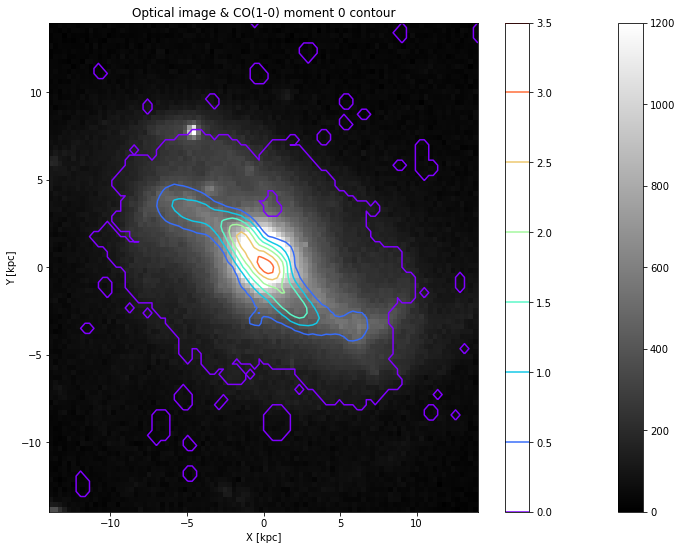

In [33]:
final_image=gdata+rdata+idata+zdata
plt.figure(figsize=(12,9))
center=[np.int(rheader["CRPIX1"]),np.int(rheader["CRPIX1"])]
final_image2=final_image[center[0]-48:center[0]+48, center[0]-48:center[0]+48]

plt.pcolormesh(xx_kpc,yy_kpc,final_image2,cmap='gray',vmin=0,vmax=1200), plt.colorbar()
plt.contour(xx_kpc,yy_kpc,np.rot90(mrk79_mom0,k=2,axes=(0,1)),cmap='rainbow'), plt.colorbar()
plt.xlabel("X [kpc]"), plt.ylabel("Y [kpc]"), plt.title("Optical image & CO(1-0) moment 0 contour")
display()

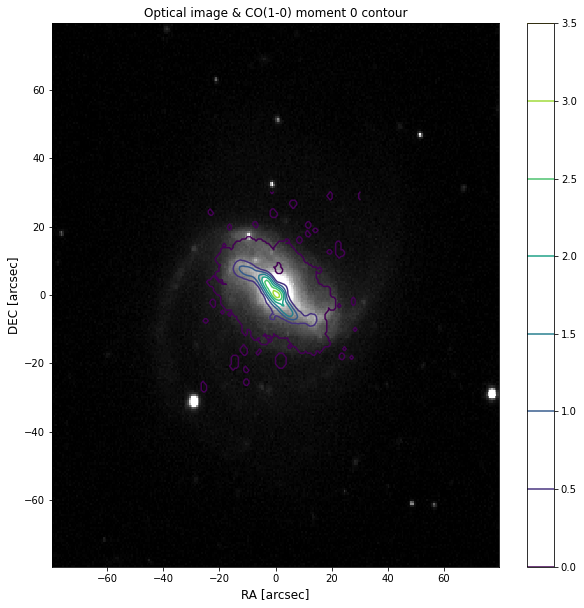

In [34]:
plt.figure(figsize=(10,10))
xx1=np.linspace(-rdata.shape[1]*dx/2.,rdata.shape[1]*dx/2.,255)#*ak #arcsec
yy1=np.linspace(-rdata.shape[1]*dx/2.,rdata.shape[1]*dx/2.,255)#*ak 
plt.pcolormesh(xx1,yy1,final_image,cmap='gray',vmin=0,vmax=800)
plt.contour(xx,yy,np.rot90(mrk79_mom0,k=-2,axes=(0,1))), plt.colorbar()
plt.xlabel("RA [arcsec]",fontsize=12), plt.ylabel("DEC [arcsec]",fontsize=12), plt.title("Optical image & CO(1-0) moment 0 contour")
plt.savefig('mrk79_opt.png', dpi=300, bbox_inches='tight')
display()